In [97]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import xgboost as xgb

In [98]:
# Display Options of DataFrame
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

In [99]:
# Loading Swap Rate Dataset
swap = pd.read_csv("../Data/market-data-swap-rates.csv")

In [100]:
swap

,Date,Start Date,Tenor,Swap Rate
0,13/1/2021,13/1/2022,10y,1.081333
1,13/1/2021,13/1/2022,15y,1.265960
2,13/1/2021,13/1/2022,18M,0.221625
3,13/1/2021,13/1/2022,1y,0.195474
4,13/1/2021,13/1/2022,2y,0.279370
...,...,...,...,...
63175,12/1/2024,12/1/2039,2y,3.424505
63176,12/1/2024,12/1/2039,3y,3.393758
63177,12/1/2024,12/1/2039,4y,3.358897
63178,12/1/2024,12/1/2039,5y,3.319531


In [101]:
swap = swap.drop_duplicates(['Date', 'Tenor'], keep = 'first') # keep the earliest quoted start date of the swap rate
swap

,Date,Start Date,Tenor,Swap Rate
0,13/1/2021,13/1/2022,10y,1.081333
1,13/1/2021,13/1/2022,15y,1.265960
2,13/1/2021,13/1/2022,18M,0.221625
3,13/1/2021,13/1/2022,1y,0.195474
4,13/1/2021,13/1/2022,2y,0.279370
...,...,...,...,...
63103,12/1/2024,13/1/2025,2y,2.982736
63104,12/1/2024,13/1/2025,3y,2.985417
63105,12/1/2024,13/1/2025,4y,3.009677
63106,12/1/2024,13/1/2025,5y,3.038587


In [102]:
swap.loc[swap['Tenor'].str.endswith("M"), 'Tenor'] = "1.5y"
swap['Tenor'] = swap['Tenor'].str.removesuffix('y')
swap['Tenor'] = swap['Tenor'].astype(float)
swap = swap.drop(columns = "Start Date")

## preprocessing

C:\Users\chanj\AppData\Local\Temp\ipykernel_20448\2701740394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap['Tenor'] = swap['Tenor'].str.removesuffix('y')
C:\Users\chanj\AppData\Local\Temp\ipykernel_20448\2701740394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap['Tenor'] = swap['Tenor'].astype(float)


In [103]:
swap.reset_index(drop = True, inplace=True)

In [104]:
#Base line model: 2y Tenor
# Subsetting
#swap_2y = swap[swap['Tenor'] == 2]
#swap_2y
subset_1 = swap[swap['Tenor'].isin([2.0, 5.0, 10.0])]
subset_2 = swap[-swap['Tenor'].isin([2.0, 5.0, 10.0])]

In [105]:
target = 'Swap Rate'
y = swap[target]
x = swap['Date'].index

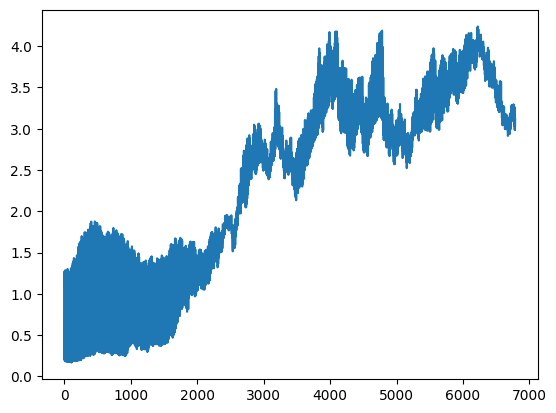

In [106]:
plt.plot(x, y)

In [107]:
y.describe()

count    6786.000000
mean        2.336816
std         1.081411
min         0.167830
25%         1.378390
50%         2.686970
75%         3.184251
max         4.239073
Name: Swap Rate, dtype: float64

In [108]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6786 entries, 0 to 6785
Series name: Swap Rate
Non-Null Count  Dtype  
--------------  -----  
6786 non-null   float64
dtypes: float64(1)
memory usage: 53.1 KB


In [109]:
# Adding plot title.
#plt.title("Autocorrelation Plot") 
 
# Providing x-axis name.
#plt.xlabel("Lags") 
 
# Plotting the Autocorrelation plot.
#plt.acorr(y, maxlags = 15) 
 
# Displaying the plot.
#print("The Autocorrelation plot for the data is:")
#plt.grid(True)
 
#plt.show() 

In [110]:
# sm.graphics.tsa.plot_pacf(y, lags=20)
# PACF cutoff at lag 1 -> AR(1) process, use lag 1 as lag variable

In [657]:
# Feature Creation
data = swap
delay = data['Tenor'].nunique()
data['Swap Rate Lag 1'] = data.groupby(['Tenor'])['Swap Rate'].shift(1)
data['Swap Rate Moving Average 2'] = data.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(2).mean().reset_index(0,drop=True)
data['Swap Rate Std 5'] = data.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(5).std().reset_index(0,drop=True)
data.head(100)

,Date,Tenor,Swap Rate,Swap Rate Lag 1,Swap Rate Moving Average 2,Swap Rate Std 5
0,13/1/2021,10.0,1.081333,NaN,NaN,NaN
1,13/1/2021,15.0,1.265960,NaN,NaN,NaN
2,13/1/2021,1.5,0.221625,NaN,NaN,NaN
3,13/1/2021,1.0,0.195474,NaN,NaN,NaN
4,13/1/2021,2.0,0.279370,NaN,NaN,NaN
5,13/1/2021,3.0,0.404284,NaN,NaN,NaN
6,13/1/2021,4.0,0.536341,NaN,NaN,NaN
7,13/1/2021,5.0,0.664396,NaN,NaN,NaN
8,13/1/2021,8.0,0.950975,NaN,NaN,NaN
9,15/1/2021,10.0,1.089143,1.081333,NaN,NaN


In [658]:
# additional feature, previous low and high


In [659]:
features = ['Swap Rate Lag 1', 'Swap Rate Moving Average 2', 'Tenor', 'Swap Rate Std 5']
y = data[target]
X = data[features]

In [660]:
# Split the data into train and test sets
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10
seed = 42
# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state = seed, shuffle=False)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = seed, shuffle=False) 


In [532]:
# initialize model
model = xgb.XGBRegressor(n_estimators = 200, 
                         enable_categorical=True, 
                         learning_rate = 0.12, 
                         max_depth = 12,
                         early_stopping_rounds = 4,
                         random_state = 42,
                         reg_alpha = 0,
                         reg_lambda = 1.12,
                         gamma = 0.03,
                         grow_policy = "depthwise",
                         max_bin = 240
                         )
model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Calculate R^2 and R^2 adj to evaluate model adequacy
y_pred = model.predict(X_test)
R_sq = sklearn.metrics.r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-R_sq)*(n-1)/(n-p-1)
print("R^2 =", R_sq) 
print("Adjusted R^2 =", adjusted_r2)

[0]	validation_0-rmse:0.88839	validation_1-rmse:1.27044
[1]	validation_0-rmse:0.78315	validation_1-rmse:1.12146
[2]	validation_0-rmse:0.69053	validation_1-rmse:0.99103
[3]	validation_0-rmse:0.60906	validation_1-rmse:0.87536
[4]	validation_0-rmse:0.53738	validation_1-rmse:0.77346
[5]	validation_0-rmse:0.47436	validation_1-rmse:0.68432
[6]	validation_0-rmse:0.41900	validation_1-rmse:0.60601
[7]	validation_0-rmse:0.37038	validation_1-rmse:0.53736
[8]	validation_0-rmse:0.32771	validation_1-rmse:0.47599
[9]	validation_0-rmse:0.29031	validation_1-rmse:0.42301
[10]	validation_0-rmse:0.25757	validation_1-rmse:0.37624
[11]	validation_0-rmse:0.22891	validation_1-rmse:0.33558
[12]	validation_0-rmse:0.20387	validation_1-rmse:0.29915
[13]	validation_0-rmse:0.18209	validation_1-rmse:0.26719
[14]	validation_0-rmse:0.16319	validation_1-rmse:0.23960
[15]	validation_0-rmse:0.14675	validation_1-rmse:0.21534
[16]	validation_0-rmse:0.13260	validation_1-rmse:0.19435
[17]	validation_0-rmse:0.12050	validation

In [680]:
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

AttributeError: 'LGBMRegressor' object has no attribute 'evals_result'

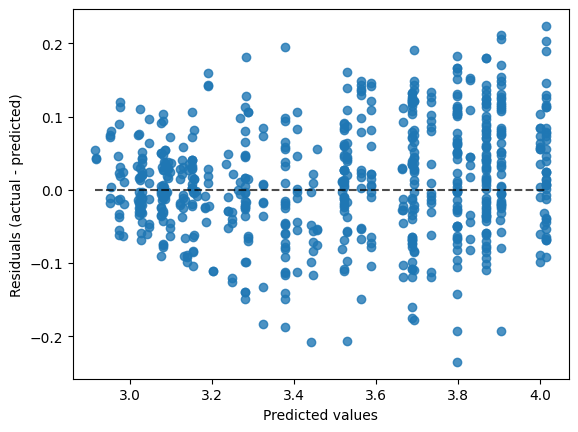

In [681]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

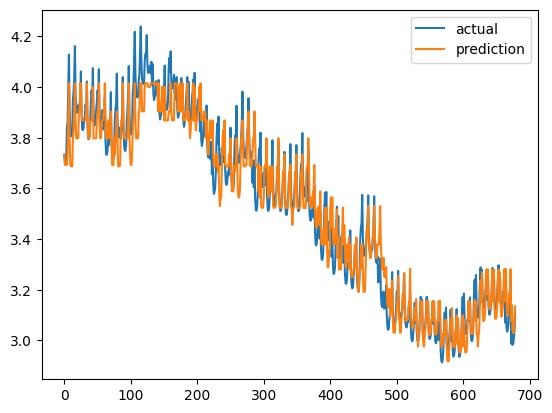

In [682]:
y_test.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='prediction')
# show the legend
plt.legend()
# show the plot
plt.show()

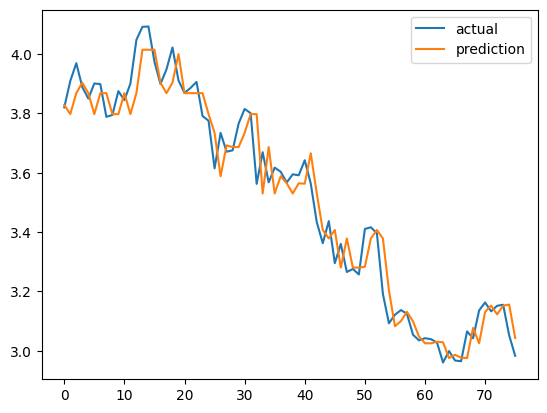

In [683]:
y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
plt.plot(y_pred2y, label='prediction')
# show the legend
plt.legend()
# show the plot
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

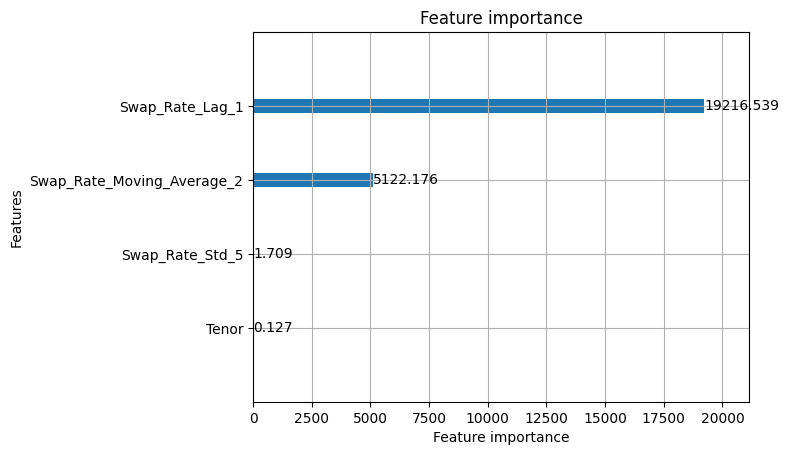

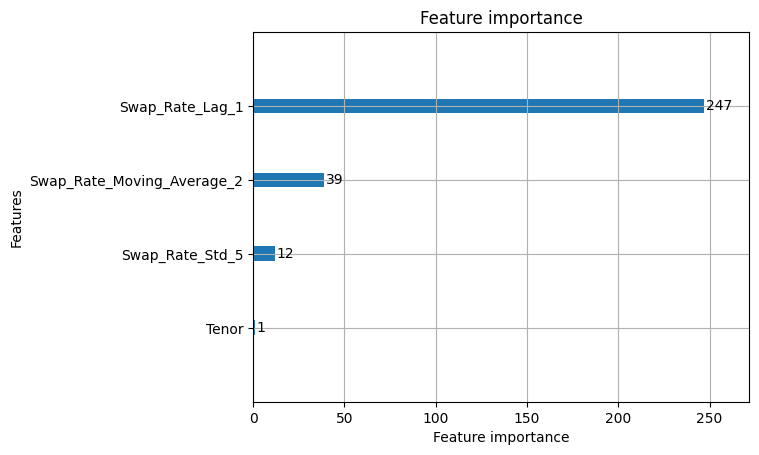

In [684]:
lgb.plot_importance(model, importance_type='gain')
lgb.plot_importance(model, importance_type='split')

In [121]:
# idea, also include prev swap rate spread max and min and median 

In [202]:
'''
import random
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distribution
param_dist = {
    'learning_rate': uniform(0.02, 0.16),
    'n_estimators': randint(50, 400),
    'max_depth': randint(6, 12),
    'early_stopping_rounds': randint(6, 10),
    'enable_categorical': [True],
    'reg_alpha': uniform(0, 2),
    'reg_lambda':uniform(0, 2)
}


# Create the XGBRegressor model
model = xgb.XGBRegressor()

# Perform randomized search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=4)
random_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)
'''

[0]	validation_0-rmse:1.02936	validation_1-rmse:1.14762
[1]	validation_0-rmse:0.87339	validation_1-rmse:0.97702
[2]	validation_0-rmse:0.74161	validation_1-rmse:0.83205
[3]	validation_0-rmse:0.63005	validation_1-rmse:0.71146
[4]	validation_0-rmse:0.53578	validation_1-rmse:0.60956
[5]	validation_0-rmse:0.45606	validation_1-rmse:0.52346
[6]	validation_0-rmse:0.38877	validation_1-rmse:0.45070
[7]	validation_0-rmse:0.33180	validation_1-rmse:0.38960
[8]	validation_0-rmse:0.28384	validation_1-rmse:0.33764
[9]	validation_0-rmse:0.24344	validation_1-rmse:0.29191
[10]	validation_0-rmse:0.20946	validation_1-rmse:0.25410
[11]	validation_0-rmse:0.18096	validation_1-rmse:0.22221
[12]	validation_0-rmse:0.15701	validation_1-rmse:0.19540
[13]	validation_0-rmse:0.13712	validation_1-rmse:0.17437
[14]	validation_0-rmse:0.12058	validation_1-rmse:0.15603
[15]	validation_0-rmse:0.10670	validation_1-rmse:0.14051
[16]	validation_0-rmse:0.09526	validation_1-rmse:0.12791
[17]	validation_0-rmse:0.08591	validation

In [203]:
'''
y_pred = random_search.predict(X_test)
R_sq = sklearn.metrics.r2_score(y_test, y_pred)
R_sq
'''

0.8788986278895314

In [606]:
#### Quantile Regression Implementation: Constant error, 
#compute the RMSE value 
error = sklearn.metrics.mean_squared_error(y_pred, y_test) ** 0.5
error


0.07808226120015355

In [473]:
y_upper = y_pred + error
y_lower = y_pred - error

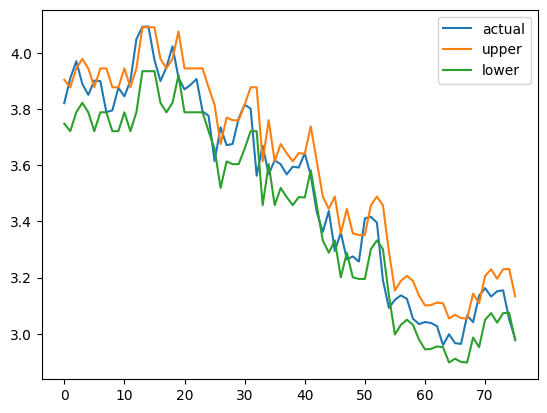

In [607]:
y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
error *= 1
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(y_pred2y + error, label='upper')
plt.plot(y_pred2y - error, label='lower')
# show the legend
plt.legend()
# show the plot
plt.show()

In [475]:
# compute the prediction error vector on the validation set 
validation_error = (model.predict(X_val) - y_val) ** 2 

In [476]:


error_model = xgb.XGBRegressor(n_estimators = 200, 
                         enable_categorical=True, 
                         learning_rate = 0.12, 
                         early_stopping_rounds = 9,
                         random_state = 42
                         )
error_model.fit(X_val,validation_error, eval_set=[(X_val, validation_error)])



[0]	validation_0-rmse:0.00721
[1]	validation_0-rmse:0.00696
[2]	validation_0-rmse:0.00673
[3]	validation_0-rmse:0.00652
[4]	validation_0-rmse:0.00635
[5]	validation_0-rmse:0.00620
[6]	validation_0-rmse:0.00608
[7]	validation_0-rmse:0.00596
[8]	validation_0-rmse:0.00586
[9]	validation_0-rmse:0.00574
[10]	validation_0-rmse:0.00566
[11]	validation_0-rmse:0.00556
[12]	validation_0-rmse:0.00549
[13]	validation_0-rmse:0.00540
[14]	validation_0-rmse:0.00532
[15]	validation_0-rmse:0.00528
[16]	validation_0-rmse:0.00523
[17]	validation_0-rmse:0.00517
[18]	validation_0-rmse:0.00512
[19]	validation_0-rmse:0.00510
[20]	validation_0-rmse:0.00502
[21]	validation_0-rmse:0.00492
[22]	validation_0-rmse:0.00484
[23]	validation_0-rmse:0.00480
[24]	validation_0-rmse:0.00474
[25]	validation_0-rmse:0.00470
[26]	validation_0-rmse:0.00466
[27]	validation_0-rmse:0.00462
[28]	validation_0-rmse:0.00460
[29]	validation_0-rmse:0.00456
[30]	validation_0-rmse:0.00449
[31]	validation_0-rmse:0.00447
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=9,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.12, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [477]:
# compute the mean and standard deviation of the distribution 
def Error(X_test):
    std_dev = (error_model.predict(X_test).astype("f8")) ** 0.5
    std_dev = np.nan_to_num(std_dev, copy = False, nan = np.nanmin(std_dev)) # imputation
    return std_dev


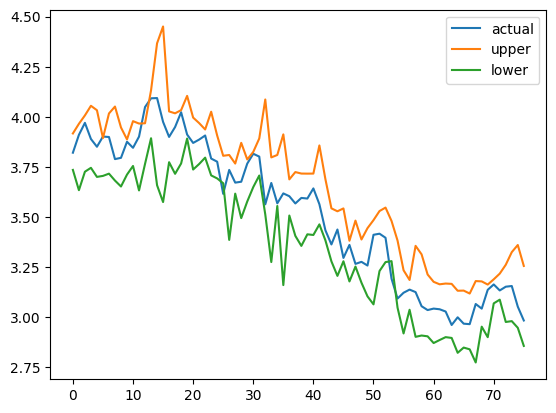

In [602]:
y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
std = Error(X_2y) * 2
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(y_pred2y + std, label='upper')
plt.plot(y_pred2y - std, label='lower')
# show the legend
plt.legend()
# show the plot
plt.show()
# error prediction model is more sensitive to external change than constant variance model

In [187]:
# problem with quantile finding using constant variance/error model prediction: not minimizing quantile loss but but only prediction loss

In [ ]:
# Quantile loss 

In [533]:
# LightGBM
import lightgbm as lgb

In [679]:
# initialize model

model = lgb.LGBMRegressor(n_estimators = 200, 
                          metric = "rmse",
                          learning_rate = 0.12, 
                          num_leaves =10,
                          max_depth = 12,
                          early_stopping_round = 4,
                          random_state = 42,
                          reg_alpha = 0,
                          reg_lambda = 1.12,
                          min_split_gain = 0.08,
                          max_bin = 1000,
                          top_rate = 0.2,
                          other_rate = 0.1,
                          training_metric = True,
                          verbose = -1, force_col_wise=True
                         )
model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Calculate R^2 and R^2 adj to evaluate model adequacy
y_pred = model.predict(X_test)
R_sq = sklearn.metrics.r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-R_sq)*(n-1)/(n-p-1)
print("R^2 =", R_sq) 
print("Adjusted R^2 =", adjusted_r2)

R^2 = 0.9522567857707888
Adjusted R^2 = 0.951973443253108
